In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import datetime
import seaborn as sns
import gc
import re
# from pandarallel import pandarallel
# pandarallel.initialize()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
#显示所有列
pd.set_option('display.max_columns', 100)
#显示所有行
pd.set_option('display.max_rows', 100)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',70)

In [2]:
def read():
    train = pd.read_csv('../train.csv')
    test1 = pd.read_csv('../test2.csv')
    # labels = train['label']
    df1 = train.drop(['Unnamed: 0'], axis=1)
    df2 = test1.drop(['Unnamed: 0'], axis=1)

    df2["label"] = -1

    for col in ["android_id", "apptype", "carrier", "ntt", "media_id", "cus_type", "package", 'fea1_hash', "location"]:
        df1[col] = df1[col].astype("object")
        df2[col] = df2[col].astype("object")

    for col in ["fea_hash"]:
        df1[col] = df1[col].map(lambda x: 0 if len(str(x)) > 16 else int(x))
        df2[col] = df2[col].map(lambda x: 0 if len(str(x)) > 16 else int(x))

    for col in ["dev_height", "dev_ppi", "dev_width", "fea_hash", "label"]:
        df1[col] = df1[col].astype("int64")
        df2[col] = df2[col].astype("int64")

    df2["label"] = None

    df1["truetime"] = pd.to_datetime(df1['timestamp'], unit='ms', origin=pd.Timestamp('1970-01-01'))
    df2["truetime"] = pd.to_datetime(df2['timestamp'], unit='ms', origin=pd.Timestamp('1970-01-01'))

    df1["day"] = df1.truetime.dt.day
    df2["day"] = df2.truetime.dt.day

    df1["hour"] = df1.truetime.dt.hour
    df2["hour"] = df2.truetime.dt.hour

    df1["minute"] = df1.truetime.dt.minute
    df2["minute"] = df2.truetime.dt.minute

    df1.set_index("sid", drop=True, inplace=True)
    df2.set_index("sid", drop=True, inplace=True)

    df1.dev_height[df1.dev_height == 0] = None
    df1.dev_width[df1.dev_width == 0] = None
    df1.dev_ppi[df1.dev_ppi == 0] = None
    df2.dev_height[df2.dev_height == 0] = None
    df2.dev_width[df2.dev_width == 0] = None
    df2.dev_ppi[df2.dev_ppi == 0] = None

    return df1, df2
df_train,df_test=read()

In [3]:
df_train.dtypes

android_id            object
apptype               object
carrier               object
dev_height           float64
dev_ppi              float64
dev_width            float64
label                  int64
lan                   object
media_id              object
ntt                   object
os                    object
osv                   object
package               object
timestamp            float64
version               object
fea_hash               int64
location              object
fea1_hash             object
cus_type              object
truetime      datetime64[ns]
day                    int64
hour                   int64
minute                 int64
dtype: object

In [4]:
def summary_stats_table(data):
    '''
    祖传代码：分类型按列的数据分布与异常值统计
    '''
    # 空值数量
    missing_counts = pd.DataFrame(data.isnull().sum())
    missing_counts.columns = ['count_null']

    # 数值列数据分布统计
    num_stats = data.select_dtypes(include=['int64','float64','int32']).describe().loc[['count','min','max','25%','50%','75%']].transpose()
    num_stats['dtype'] = data.select_dtypes(include=['int64','float64','int32']).dtypes.tolist()

    # 非数值列数据分布统计
    non_num_stats = data.select_dtypes(exclude=['int64','float64','int32']).describe().transpose()
    non_num_stats['dtype'] = data.select_dtypes(exclude=['int64','float64','int32']).dtypes.tolist()
    non_num_stats = non_num_stats.rename(columns={"first": "min", "last": "max"})

    # 聚合结果
    stats_merge = pd.concat([num_stats, non_num_stats], axis=0, join='outer', ignore_index=False, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True, sort=False).fillna("").sort_values('dtype')

    column_order = ['dtype', 'count', 'count_null','unique','min','max','25%','50%','75%','top','freq']
    summary_stats = pd.merge(stats_merge, missing_counts, left_index=True, right_index=True, sort=False)[column_order]
    return(summary_stats)
summary_stats_table(df_train)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
minute,int64,500000.0,0,,0,59,14,29,44,,
hour,int64,500000.0,0,,0,23,5,10,14,,
day,int64,500000.0,0,,2,9,4,6,8,,
fea_hash,int64,500000.0,0,,0,4.29494e+09,1.03451e+09,2.08719e+09,3.17491e+09,,
dev_height,float64,392986.0,107014,,7,9024,960,1920,2160,,
truetime,datetime64[ns],500000.0,0,500000,2019-06-02 16:00:01.174781250,2019-06-09 16:00:04.317492432,,,,2019-06-08 16:53:01.408521240,1
label,int64,500000.0,0,,0,1,0,0,1,,
dev_width,float64,392989.0,107011,,200,8832,720,1080,1080,,
dev_ppi,float64,116709.0,383291,,1,720,3,480,480,,
timestamp,float64,500000.0,0,,1.55949e+12,1.5601e+12,1.55966e+12,1.55982e+12,1.55996e+12,,


In [5]:
summary_stats_table(df_test)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
minute,int64,150000.0,0,,0,59,14,29,44,,
hour,int64,150000.0,0,,0,23,5,10,14,,
day,int64,150000.0,0,,2,9,4,6,8,,
dev_height,float64,117568.0,32432,,8,9024,960,1920,2160,,
truetime,datetime64[ns],150000.0,0,150000,2019-06-02 16:00:01.554341309,2019-06-09 15:59:56.694173828,,,,2019-06-03 13:36:17.623276855,1
fea_hash,int64,150000.0,0,,0,4.29489e+09,1.0376e+09,2.1002e+09,3.19196e+09,,
timestamp,float64,150000.0,0,,1.55949e+12,1.5601e+12,1.55966e+12,1.55982e+12,1.55997e+12,,
dev_width,float64,117571.0,32429,,150,8832,720,1080,1080,,
dev_ppi,float64,34910.0,115090,,1,720,3,480,480,,
cus_type,object,150000.0,0,58,,,,,,411,40224


## 一、类别变量编码与特征工程
### 1.特征apptype label Encoder：对分类型特征值进行编码
发现df_test 中所有的apptype都会被df_train 包括

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
set1=set(df_train["apptype"].value_counts().head(75).index)
def process_apptype(x):
    if x in set1:
        return x
    else:
        return -1

df_train["apptype"]=df_train["apptype"].apply(process_apptype)
df_test["apptype"]=df_test["apptype"].apply(process_apptype)

df_train.apptype=le.fit_transform(df_train.apptype)
df_train["apptype"]=df_train["apptype"].astype("object")

df_test.apptype=le.transform(df_test.apptype)
df_test["apptype"]=df_test["apptype"].astype("object")

### 2.特征carrier label Encoder：对分类型特征值进行编码
设备使用的运营商 0-未知, 46000-移动, 46001-联通, 46003-电信,-1当成未知

In [7]:
dict1={0.0:0, 46000.0:1, 46001.0:2, 46003.0:3,-1.0:-1}
df_train.carrier=df_train.carrier.map(dict1)
df_train["carrier"]=df_train["carrier"].astype("object")

df_test.carrier=df_test.carrier.map(dict1)
df_test["carrier"]=df_test["carrier"].astype("object")

### 10.media_id:媒体信息，对外媒体ID

test 与train 非对应

非对应的id最高出现不超过10次(head200)

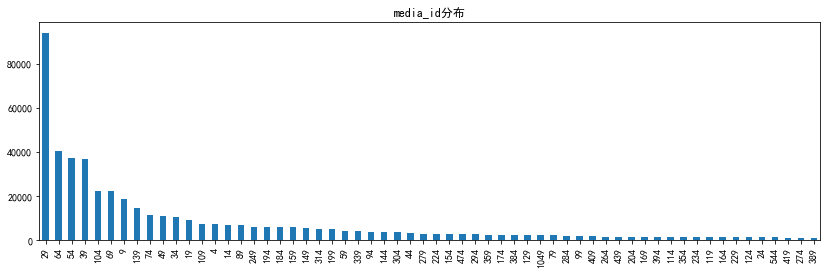

In [8]:
plt.figure(figsize=(14,4))
plt.title('media_id分布')
df_train["media_id"].value_counts().head(60).plot(kind="bar");

In [8]:
def cross_col(col):
    atrd=[]
    ated=[]
    for num in df_test[col].unique():
        if num not in df_train[col].unique():
            ated.append(num)
    for num in df_train[col].unique():
        if num not in df_test[col].unique():
            atrd.append(num)
    print("只存在test里:",ated)
    print("只存在train里:",atrd) 
cross_col("media_id")

只存在test里: [1479, 1364, 1339, 1029, 1124, 1509, 1469]
只存在train里: [1064, 1349, 1289, 1329, 644, 1019, 1394, 1414, 1489, 1069, 1269, 1264, 1389, 1214, 1259, 1204, 1529, 1254, 969, 1099, 1319, 1429, 1434, 1399, 1424, 1379, 1374, 1334, 1104, 959, 1544, 1499, 1199, 1239, 1219]


In [9]:
set2=set(df_train["media_id"].value_counts().head(200).index)
def process_media_id(x):
    if x in set2:
        return x
    else:
        return -1

df_train["media_id"]=df_train["media_id"].apply(process_media_id)
df_test["media_id"]=df_test["media_id"].apply(process_media_id)

from sklearn import preprocessing
le5 = preprocessing.LabelEncoder()

df_train.media_id=le5.fit_transform(df_train.media_id)
df_train["media_id"]=df_train["media_id"].astype("object")

df_test.media_id=le5.transform(df_test.media_id)
df_test["media_id"]=df_test["media_id"].astype("object")

cross_col("media_id")

只存在test里: []
只存在train里: []


### 11.ntt:网络类型 0-未知, 1-有线网, 2-WIFI, 3-蜂窝网络未知, 4-2G, 5-3G, 6–4G

In [10]:
from sklearn import preprocessing
le6 = preprocessing.LabelEncoder()

df_train.ntt=le6.fit_transform(df_train.ntt)
df_train["ntt"]=df_train["ntt"].astype("object")

df_test.ntt=le6.transform(df_test.ntt)
df_test["ntt"]=df_test["ntt"].astype("object")

cross_col("ntt")

只存在test里: []
只存在train里: [1]


### 3.dev_height	:设备高   dev_width:设备宽
0的数据过多(1/5)，还原成Nan的，不是整数的数据都是少数

### 4.dev_ppi:屏幕分辨率
0还是多(4/5)

In [11]:
# df_train.dev_height[df_train.dev_height==0]=None
# df_train.dev_width[df_train.dev_width==0]=None
# df_train.dev_ppi[df_train.dev_ppi==0]=None
# df_test.dev_height[df_test.dev_height==0]=None
# df_test.dev_width[df_test.dev_width==0]=None
# df_test.dev_ppi[df_test.dev_ppi==0]=None

### 4.1 RF 预测dev_ppi

In [12]:
gc.collect()
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

c1=df_train.dev_width.notnull()
c2=df_train.dev_height.notnull()
c3=df_train.dev_ppi.isna()
c4=df_train.dev_ppi.notnull()
df_train["mynull1"]=c1&c2&c3
df_train["mynull2"]=c1&c2&c4

predict=df_train[["apptype","carrier","dev_height","dev_ppi","dev_width","media_id","ntt","mynull1","mynull2"]]

df_notnans = predict[predict.mynull2==True]

# Split into 75% train and 25% test
X_train, X_test, y_train, y_test = train_test_split(df_notnans[["apptype","carrier","dev_height","dev_width","media_id","ntt"]], df_notnans["dev_ppi"],train_size=0.75, random_state=6)

regr_multirf = RandomForestClassifier(n_estimators=100,max_depth=40, random_state=0,n_jobs=-1)

# Fit on the train data
regr_multirf.fit(X_train, y_train)

# Check the prediction score
score = regr_multirf.score(X_test, y_test)
print("The prediction score on the test data is {:.2f}%".format(score*100))

The prediction score on the test data is 97.39%


#### 给train做预测

In [13]:
df_nans = predict[predict.mynull1==True].copy()
df_nans["dev_ppi_pred"] = regr_multirf.predict(df_nans[["apptype","carrier","dev_height","dev_width","media_id","ntt"]])
df_train=pd.merge(df_train,df_nans["dev_ppi_pred"],on="sid",how="left")

#### 给test做预测

In [14]:
c1=df_test.dev_width.notnull()
c2=df_test.dev_height.notnull()
c3=df_test.dev_ppi.isna()
c4=df_test.dev_ppi.notnull()
df_test["mynull1"]=c1&c2&c3
df_test["mynull2"]=c1&c2&c4

predict_test=df_test[["apptype","carrier","dev_height","dev_ppi","dev_width","media_id","ntt","mynull1","mynull2"]]
df_nans = predict_test[predict_test.mynull1==True].copy()
df_nans["dev_ppi_pred"] = regr_multirf.predict(df_nans[["apptype","carrier","dev_height","dev_width","media_id","ntt"]])
df_test=pd.merge(df_test,df_nans["dev_ppi_pred"],on="sid",how="left")

In [15]:
def recol_ppi(df):
    a=df.dev_ppi.fillna(0).values
    b=df.dev_ppi_pred.fillna(0).values
    c=[]
    # print(a,b)
    for i in range(len(a)):
        c.append(max(a[i],b[i]))
    c=np.array(c)
    df["final_ppi"]=c
    df["final_ppi"][df["final_ppi"]==0]=None
    return df
df_train=recol_ppi(df_train)
df_test=recol_ppi(df_test)

### 5.构造新特征：能否被160整除 // 高宽比 // 根据ppi公式反推inch

In [16]:
# df_train.dev_height.value_counts().head(40)

In [17]:
def divided(x):
    if x%40==0:
        return 2
    elif not x:
        return 1
    else:
        return 0

df_train["160_height"]=df_train.dev_height.apply(divided)
df_test["160_height"]=df_test.dev_height.apply(divided)
df_train["160_width"]=df_train.dev_width.apply(divided)
df_test["160_width"]=df_test.dev_width.apply(divided)
df_train["160_ppi"]=df_train.final_ppi.apply(divided)
df_test["160_ppi"]=df_test.final_ppi.apply(divided)

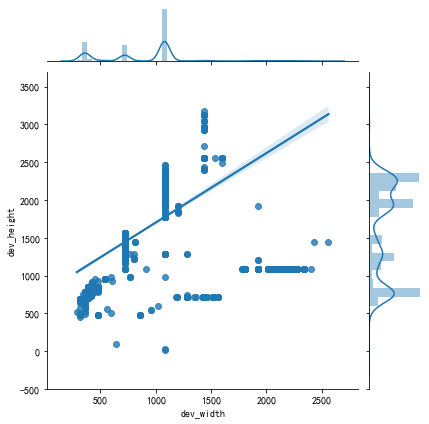

In [19]:
sns.jointplot(x="dev_width",y="dev_height",data=df_train[:10000],kind="reg");

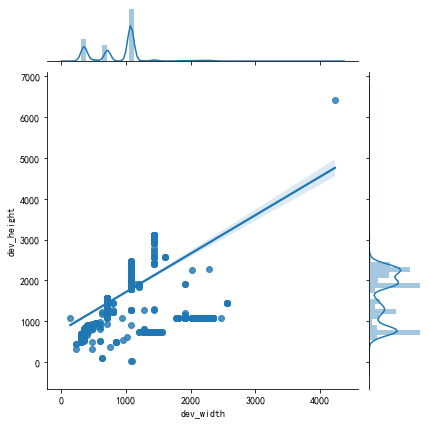

In [62]:
sns.jointplot(x="dev_width",y="dev_height",data=df_test[:10000],kind="reg");

In [18]:
df_train["hw_ratio"]=df_train.dev_height/df_train.dev_width
df_test["hw_ratio"]=df_test.dev_height/df_test.dev_width

In [19]:
df_train["hw_matrix"]=df_train.dev_height*df_train.dev_width
df_test["hw_matrix"]=df_test.dev_height*df_test.dev_width

In [20]:
df_train["inch"]=(df_train.dev_height**2+df_train.dev_width**2)**0.5/df_train.final_ppi
df_test["inch"]=(df_test.dev_height**2+df_test.dev_width**2)**0.5/df_test.final_ppi

In [23]:
df_train.head(20)

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,os,osv,package,timestamp,version,fea_hash,location,fea1_hash,cus_type,truetime,day,hour,minute,mynull1,mynull2,dev_ppi_pred,final_ppi,160_height,160_width,160_ppi,hw_ratio,hw_matrix,inch
sid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1438873,316361,68,1,NaN,NaN,NaN,1,NaN,22,6,android,9,18,1.559893e+12,8,2135019403,0,2329670524,601,2019-06-07 07:32:08.241721191,7,7,32,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN
1185582,135939,29,0,NaN,NaN,NaN,1,NaN,5,6,android,8.1,0,1.559994e+12,4,2782306428,1,2864801071,1000,2019-06-08 11:40:20.922228760,8,11,40,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN
1555716,399254,22,0,760.0,NaN,360.0,1,NaN,112,0,android,8.1.0,0,1.559837e+12,0,1392806005,2,628911675,696,2019-06-06 15:58:17.549108643,6,15,58,True,False,2.0,2.0,2,2,0,2.111111,273600.0,420.475921
1093419,68983,45,1,2214.0,NaN,1080.0,0,NaN,27,2,android,8.1.0,0,1.560042e+12,0,3562553457,3,1283809327,753,2019-06-09 00:59:37.719684814,9,0,59,True,False,480.0,480.0,0,2,2,2.050000,2391120.0,5.132023
1400089,288999,56,1,2280.0,NaN,1080.0,1,zh-CN,14,2,android,8.0.0,0,1.559867e+12,5,2364522023,4,1510695983,582,2019-06-07 00:28:21.478552734,7,0,28,True,False,2.0,2.0,2,2,0,2.111111,2462400.0,1261.427762
1253737,184658,18,1,2196.0,480.0,1080.0,1,zh-CN,39,6,Android,8.1.0,35,1.559976e+12,5,1655793887,5,1080320295,430,2019-06-08 06:34:10.366265869,8,6,34,False,True,NaN,480.0,0,2,2,2.033333,2371680.0,5.098345
1387136,0,59,1,NaN,NaN,NaN,0,NaN,9,0,android,9,123,1.559845e+12,0,369486452,6,4190764663,411,2019-06-06 18:12:48.395789062,6,18,12,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN
1597216,0,44,1,760.0,NaN,360.0,1,zh-CN,7,2,Android,8.1.0,4,1.559783e+12,0,3912031003,7,2627690535,411,2019-06-06 01:02:11.781200928,6,1,2,True,False,1.0,1.0,2,2,0,2.111111,273600.0,840.951842
1910989,646994,29,0,NaN,NaN,NaN,0,NaN,5,6,android,8.1,0,1.559549e+12,4,3307888762,8,2961728815,886,2019-06-03 08:01:24.868135254,3,8,1,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN


### 7.location:地理位置

In [21]:
from sklearn import preprocessing
le2 = preprocessing.LabelEncoder()

df_train.location=le2.fit_transform(df_train.location)
df_train["location"]=df_train["location"].astype("object")

df_test.location=le2.transform(df_test.location)
df_test["location"]=df_test["location"].astype("object")

### 8.version:

In [22]:
df_test.version=df_test.version.replace("20","0").replace("21","0")

le3 = preprocessing.LabelEncoder()

df_train.version=le3.fit_transform(df_train.version)
df_train["version"]=df_train["version"].astype("object")

df_test.version=le3.transform(df_test.version)
df_test["version"]=df_test["version"].astype("object")

### 9.lan

train 和test 的标志不一致

只规划大于10个的标志，其余的规划为UNK(包括Nan)

In [23]:
def process_lan(x):
    set1=set(['zh-CN', 'zh', 'cn', 'zh_CN', 'Zh-CN', 'zh-cn', 'ZH', 'CN', 'tw', 'en','zh_CN_#Hans', 'ko'])
    if x in set1:
        return x
    else:
        return "unk"

In [24]:
def foreign_lan(x):
    set2=set(['zh-CN', 'zh', 'cn', 'zh_CN', 'Zh-CN', 'zh-cn', 'ZH', 'CN','zh_CN_#Hans'])
    if x in set2:
        return 0
    elif x=="unk":
        return 2
    else:
        return 1

In [25]:
df_train["vpn"]=df_train["lan"].apply(foreign_lan)
df_test["vpn"]=df_test["lan"].apply(foreign_lan)

In [26]:
df_train["lan"]=df_train["lan"].apply(process_lan)
df_test["lan"]=df_test["lan"].apply(process_lan)

from sklearn import preprocessing
le4 = preprocessing.LabelEncoder()

df_train.lan=le4.fit_transform(df_train.lan)
df_train["lan"]=df_train["lan"].astype("object")

df_test.lan=le4.transform(df_test.lan)
df_test["lan"]=df_test["lan"].astype("object")

### 12.os

In [27]:
from sklearn import preprocessing
le7 = preprocessing.LabelEncoder()

df_train.os=le7.fit_transform(df_train.os)
df_train["os"]=df_train["os"].astype("object")

df_test.os=le7.transform(df_test.os)
df_test["os"]=df_test["os"].astype("object")

### 13.osv:
这版本也太多了把，用正则表达式匹配数字

这里用粗略匹配，用第一个数字表示版本，转换成为int64

In [28]:
def process_osv(x):
    x=str(x)
    if not x:
        return -1
    elif x.startswith("Android"):
        x=str(re.findall("\d{1}\.*\d*\.*\d*",x)[0])
        return x
    elif x.isdigit():
        return x
    else:
        try:
            x=str(re.findall("\d{1}\.\d\.*\d*",x)[0])
            return x
        except:
            return 0

In [29]:
df_train.osv=df_train.osv.apply(process_osv)
df_test.osv=df_test.osv.apply(process_osv)

In [30]:
set3=set(df_train["osv"].value_counts().head(70).index)
def process_osv(x):
    if x in set3:
        return x
    else:
        return 0

In [31]:
df_train["osv"]=df_train["osv"].apply(process_osv)
df_test["osv"]=df_test["osv"].apply(process_osv)

In [32]:
cross_col("osv")

只存在test里: []
只存在train里: []


In [33]:
from sklearn import preprocessing
le8 = preprocessing.LabelEncoder()

df_train.osv=le8.fit_transform(df_train.osv.astype("str"))
df_train["osv"]=df_train["osv"].astype("object")

df_test.osv=le8.transform(df_test.osv.astype("str"))
df_test["osv"]=df_test["osv"].astype("object")

14.package:媒体信息，包名（已加密）

In [34]:
set3=set(df_train.package.value_counts().head(800).index)
def process_package(x):
    if x in set3:
        return x
    else:
        return -1

In [35]:
df_train.package=df_train.package.apply(process_package)
df_test.package=df_test.package.apply(process_package)

In [36]:
cross_col("package")
gc.collect()

只存在test里: []
只存在train里: [825, 1330, 1053, 1282, 769, 1525, 984, 350, 1133, 1022, 880, 1674, 1049, 176, 860, 1253, 341, 588, 607, 83, 690, 1827, 118, 822, 1193, 189, 1267, 772, 905, 887, 1055, 59, 745, 1911, 1584, 1108, 1681, 629, 148, 106, 390, 144, 547, 961, 1341, 1012, 239, 725, 1368, 829, 648, 918, 979, 682, 781, 874, 1148, 1024]


512

In [37]:
from sklearn import preprocessing
le18 = preprocessing.LabelEncoder()

df_train.package=le18.fit_transform(df_train.package)
df_train["package"]=df_train["package"].astype("object")

df_test.package=le18.transform(df_test.package)
df_test["package"]=df_test["package"].astype("object")

### 15.fea_hash:int64

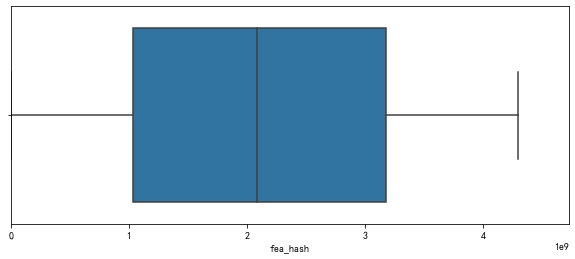

In [39]:
plt.figure(figsize=(10,4))
# x轴坐标范围
plt.xlim(df_train.fea_hash.min(), df_train.fea_hash.max()*1.1)
sns.boxplot(x=df_train.fea_hash)
plt.show()

### 16.fea1_hash

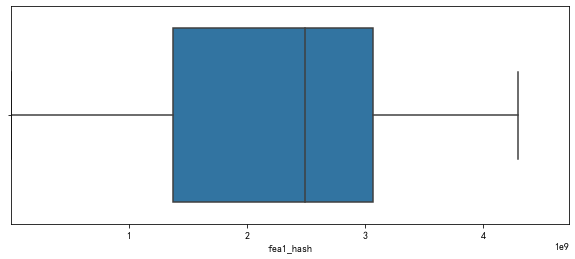

In [38]:
plt.figure(figsize=(10,4))
# x轴坐标范围
plt.xlim(df_train.fea1_hash.min(), df_train.fea1_hash.max()*1.1)
sns.boxplot(x=df_train.fea1_hash)
plt.show()

In [39]:
set5=set(df_train.fea_hash.value_counts().head(850).index)
def process_fea_hash(x):
    if x in set5:
        return x
    else:
        return -1
df_train.fea_hash=df_train.fea_hash.apply(process_fea_hash)
df_test.fea_hash=df_test.fea_hash.apply(process_fea_hash)

In [41]:
from sklearn import preprocessing
le12 = preprocessing.LabelEncoder()

df_train.fea_hash=le12.fit_transform(df_train.fea_hash)
df_train["fea_hash"]=df_train["fea_hash"].astype("object")

df_test.fea_hash=le12.transform(df_test.fea_hash)
df_test["fea_hash"]=df_test["fea_hash"].astype("object")

In [42]:
set4=set(df_train.fea1_hash.value_counts().head(850).index)
def process_fea1_hash(x):
    if x in set4:
        return x
    else:
        return -1

In [43]:
df_train.fea1_hash=df_train.fea1_hash.apply(process_fea1_hash)
df_test.fea1_hash=df_test.fea1_hash.apply(process_fea1_hash)

In [44]:
from sklearn import preprocessing
le9 = preprocessing.LabelEncoder()

df_train.fea1_hash=le9.fit_transform(df_train.fea1_hash)
df_train["fea1_hash"]=df_train["fea1_hash"].astype("object")

df_test.fea1_hash=le9.transform(df_test.fea1_hash)
df_test["fea1_hash"]=df_test["fea1_hash"].astype("object")

### 17.cus_type

In [45]:
from sklearn import preprocessing
le10 = preprocessing.LabelEncoder()

df_train.cus_type=le10.fit_transform(df_train.cus_type)
df_train["cus_type"]=df_train["cus_type"].astype("object")

df_test.cus_type=le10.transform(df_test.cus_type)
df_test["cus_type"]=df_test["cus_type"].astype("object")

### 18.android_id

In [46]:
# set4=set(df_train.android_id.value_counts().head(8164).index)
# def process_android_id_train(x):
#     if x in set4:
#         return x
#     else:
#         return -1

In [47]:
# df_train.android_id=df_train.android_id.apply(process_android_id_train)
# df_test.android_id=df_test.android_id.apply(process_android_id_train)

In [48]:
# le11 = preprocessing.LabelEncoder()

# df_train.android_id=le11.fit_transform(df_train.android_id)
# df_train["android_id"]=df_train["android_id"].astype("object")

# df_test.android_id=le11.transform(df_test.android_id)
# df_test["android_id"]=df_test["android_id"].astype("object")

### summary

In [47]:
summary_stats_table(df_train)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
mynull2,bool,500000.0,0,2,,,,,,False,384076
truetime,datetime64[ns],500000.0,0,500000,2019-06-02 16:00:01.174781250,2019-06-09 16:00:04.317492432,,,,2019-06-08 16:53:01.408521240,1
mynull1,bool,500000.0,0,2,,,,,,True,277062
160_ppi,int64,500000.0,0,,0,2,0,0,2,,
160_width,int64,500000.0,0,,0,2,0,2,2,,
160_height,int64,500000.0,0,,0,2,0,0,2,,
minute,int64,500000.0,0,,0,59,14,29,44,,
vpn,int64,500000.0,0,,0,1,0,0,1,,
day,int64,500000.0,0,,2,9,4,6,8,,
hour,int64,500000.0,0,,0,23,5,10,14,,


In [48]:
summary_stats_table(df_test)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
mynull2,bool,150000.0,0,2,,,,,,False,115527
truetime,datetime64[ns],150000.0,0,150000,2019-06-02 16:00:03.414976318,2019-06-09 15:59:44.637749512,,,,2019-06-07 00:14:39.307900635,1
mynull1,bool,150000.0,0,2,,,,,,True,83328
vpn,int64,150000.0,0,,0,1,0,0,1,,
day,int64,150000.0,0,,2,9,4,6,8,,
hour,int64,150000.0,0,,0,23,5,10,14,,
minute,int64,150000.0,0,,0,59,14,29,44,,
160_height,int64,150000.0,0,,0,2,0,0,2,,
160_width,int64,150000.0,0,,0,2,0,2,2,,
160_ppi,int64,150000.0,0,,0,2,0,0,2,,


In [49]:
df_train.to_pickle("../processed_data/df_train2.pkl")
df_test.to_pickle("../processed_data/df_test2.pkl")

In [9]:
import pandas as pd
import gc
#显示所有列
pd.set_option('display.max_columns', 100)
#显示所有行
pd.set_option('display.max_rows', 100)

df_train1=pd.read_pickle("../processed_data/df_train2.pkl")
# feature_test=pd.read_pickle("../processed_data/df_test2.pkl")
df_train2=pd.read_pickle("../processed_data/df_train3.pkl")
df_train2=df_train2[['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi',
       'dev_width', 'label', 'lan', 'media_id', 'ntt', 'os', 'osv', 'package',
       'timestamp', 'version', 'fea_hash', 'location', 'fea1_hash', 'cus_type',
       'truetime', 'day', 'hour', 'minute', 'mynull1', 'mynull2',
       'dev_ppi_pred', 'final_ppi', '160_height', '160_width', '160_ppi',
       'hw_ratio', 'hw_matrix', 'inch', 'vpn']]
# feature_test=pd.read_pickle("../processed_data/df_test2.pkl")

In [10]:
# df_train1["import"]="my"
# df_train2["import"]="your"
df_train=df_train1.append(df_train2)
df_train=df_train.reset_index()
# del df_train1
# del df_train2
# gc.collect()

In [11]:
df_train

,sid,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,os,osv,package,timestamp,version,fea_hash,location,fea1_hash,cus_type,truetime,day,hour,minute,mynull1,mynull2,dev_ppi_pred,final_ppi,160_height,160_width,160_ppi,hw_ratio,hw_matrix,inch,vpn
0,1438873,316361,68,1,NaN,NaN,NaN,1,7,21,6,1,66,19,1.559893e+12,13,0,1,433,16,2019-06-07 07:32:08.241721191,7,7,32,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN,1
1,1185582,135939,29,0,NaN,NaN,NaN,1,7,4,6,1,64,1,1.559994e+12,8,0,2,534,37,2019-06-08 11:40:20.922228760,8,11,40,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN,1
2,1555716,399254,22,0,760.0,NaN,360.0,1,7,111,0,1,65,1,1.559837e+12,1,0,3,110,21,2019-06-06 15:58:17.549108643,6,15,58,True,False,2.0,2.0,2,2,0,2.111111,273600.0,420.475921,1
3,1093419,68983,45,1,2214.0,NaN,1080.0,0,7,26,2,1,65,1,1.560042e+12,1,0,4,230,24,2019-06-09 00:59:37.719684814,9,0,59,True,False,480.0,480.0,0,2,2,2.050000,2391120.0,5.132023,1
4,1400089,288999,56,1,2280.0,NaN,1080.0,1,9,13,2,1,62,1,1.559867e+12,9,0,5,279,15,2019-06-07 00:28:21.478552734,7,0,28,True,False,2.0,2.0,2,2,0,2.111111,2462400.0,1261.427762,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1546078,392477,49,1,1920.0,3.0,1080.0,1,9,29,6,0,40,26,1.559834e+12,12,0,80,28,4,2019-06-06 15:14:18.267241699,6,15,14,False,True,NaN,3.0,2,2,0,1.777778,2073600.0,734.302390,0
999996,1480612,346134,44,0,1424.0,NaN,720.0,0,7,6,2,1,65,1,1.559814e+12,7,0,24,505,12,2019-06-06 09:40:54.045280518,6,9,40,True,False,2.0,2.0,0,2,0,1.977778,1025280.0,797.837076,1
999997,1698442,499635,12,1,1280.0,NaN,720.0,0,7,11,6,1,32,10,1.559676e+12,1,0,26,241,27,2019-06-04 19:14:57.290064453,4,19,14,True,False,320.0,320.0,2,2,2,1.777778,921600.0,4.589390,1
999998,1331155,239786,33,2,960.0,NaN,540.0,0,11,22,2,1,28,1,1.559840e+12,1,0,226,267,25,2019-06-06 16:59:27.651520996,6,16,59,True,False,3.0,3.0,2,0,0,1.777778,518400.0,367.151195,0


In [12]:
df_train.drop_duplicates()

,sid,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,os,osv,package,timestamp,version,fea_hash,location,fea1_hash,cus_type,truetime,day,hour,minute,mynull1,mynull2,dev_ppi_pred,final_ppi,160_height,160_width,160_ppi,hw_ratio,hw_matrix,inch,vpn
0,1438873,316361,68,1,NaN,NaN,NaN,1,7,21,6,1,66,19,1.559893e+12,13,0,1,433,16,2019-06-07 07:32:08.241721191,7,7,32,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN,1
1,1185582,135939,29,0,NaN,NaN,NaN,1,7,4,6,1,64,1,1.559994e+12,8,0,2,534,37,2019-06-08 11:40:20.922228760,8,11,40,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN,1
2,1555716,399254,22,0,760.0,NaN,360.0,1,7,111,0,1,65,1,1.559837e+12,1,0,3,110,21,2019-06-06 15:58:17.549108643,6,15,58,True,False,2.0,2.0,2,2,0,2.111111,273600.0,420.475921,1
3,1093419,68983,45,1,2214.0,NaN,1080.0,0,7,26,2,1,65,1,1.560042e+12,1,0,4,230,24,2019-06-09 00:59:37.719684814,9,0,59,True,False,480.0,480.0,0,2,2,2.050000,2391120.0,5.132023,1
4,1400089,288999,56,1,2280.0,NaN,1080.0,1,9,13,2,1,62,1,1.559867e+12,9,0,5,279,15,2019-06-07 00:28:21.478552734,7,0,28,True,False,2.0,2.0,2,2,0,2.111111,2462400.0,1261.427762,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996927,1822321,585860,37,-1,NaN,NaN,NaN,1,7,15,2,1,42,17,1.559628e+12,1,0,301,23,9,2019-06-04 06:00:00.890911865,4,6,0,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN,1
997782,1146005,107278,37,-1,NaN,NaN,NaN,1,7,15,6,1,46,17,1.560066e+12,1,0,7,23,15,2019-06-09 07:32:55.197456787,9,7,32,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN,1
997854,1165412,121349,37,-1,NaN,NaN,NaN,1,7,15,6,1,47,17,1.559962e+12,1,0,53,23,14,2019-06-08 02:44:48.161963135,8,2,44,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN,1
998246,1548725,394348,37,-1,NaN,NaN,NaN,1,7,15,6,1,48,17,1.559813e+12,1,0,7,23,33,2019-06-06 09:22:50.852362305,6,9,22,False,False,NaN,NaN,0,0,0,NaN,NaN,NaN,1


In [58]:
df_train1.iloc[998246-500000,:]

android_id                             394348
apptype                                    37
carrier                                    -1
dev_height                                NaN
dev_ppi                                   NaN
dev_width                                 NaN
label                                       1
lan                                         7
media_id                                   15
ntt                                         6
os                                          1
osv                                         0
package                                    17
timestamp                         1.55981e+12
version                                     1
fea_hash                                    0
location                                    7
fea1_hash                                  23
cus_type                                   33
truetime        2019-06-06 09:22:50.852362305
day                                         6
hour                              

In [59]:
df_train2.iloc[998246-500000,:]

android_id                             394348
apptype                                    37
carrier                                    -1
dev_height                                NaN
dev_ppi                                   NaN
dev_width                                 NaN
label                                       1
lan                                         7
media_id                                   15
ntt                                         6
os                                          1
osv                                        48
package                                    17
timestamp                         1.55981e+12
version                                     1
fea_hash                                    0
location                                    7
fea1_hash                                  23
cus_type                                   33
truetime        2019-06-06 09:22:50.852362305
day                                         6
hour                              

In [26]:
df_train2

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,...,mynull2,dev_ppi_pred,final_ppi,160_height,160_width,160_ppi,hw_ratio,hw_matrix,inch,vpn
sid,,,,,,,,,,,,,,,,,,,,,
1438873,316361,68,1,NaN,NaN,NaN,1,7,21,6,...,False,NaN,NaN,0,0,0,NaN,NaN,NaN,1
1185582,135939,29,0,NaN,NaN,NaN,1,7,4,6,...,False,NaN,NaN,0,0,0,NaN,NaN,NaN,1
1555716,399254,22,0,760.0,NaN,360.0,1,7,111,0,...,False,2.0,2.0,2,2,0,2.111111,273600.0,420.475921,1
1093419,68983,45,1,2214.0,NaN,1080.0,0,7,26,2,...,False,480.0,480.0,0,2,2,2.050000,2391120.0,5.132023,1
1400089,288999,56,1,2280.0,NaN,1080.0,1,9,13,2,...,False,2.0,2.0,2,2,0,2.111111,2462400.0,1261.427762,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546078,392477,49,1,1920.0,3.0,1080.0,1,9,29,6,...,True,NaN,3.0,2,2,0,1.777778,2073600.0,734.302390,0
1480612,346134,44,0,1424.0,NaN,720.0,0,7,6,2,...,False,2.0,2.0,0,2,0,1.977778,1025280.0,797.837076,1
1698442,499635,12,1,1280.0,NaN,720.0,0,7,11,6,...,False,320.0,320.0,2,2,2,1.777778,921600.0,4.589390,1


In [63]:
df_train1.osv.unique()

array([66, 64, 65, 62, 26, 68, 39, 28, 55, 20, 0, 30, 32, 10, 36, 59, 58,
       40, 9, 27, 67, 50, 31, 25, 37, 15, 38, 61, 16, 19, 11, 22, 1, 23,
       51, 24, 18, 63, 47, 33, 8, 57, 49, 45, 53, 35, 48, 12, 6, 42, 5,
       52, 60, 43, 54, 29, 14, 56, 3, 46, 21, 34, 2, 17, 13, 44, 69, 7, 4,
       41], dtype=object)

In [64]:
df_train2.osv.unique()

array([66, 64, 65, 62, 26, 68, 39, 28, 55, 20, 0, 30, 32, 10, 36, 59, 58,
       40, 9, 27, 67, 50, 31, 25, 37, 15, 38, 61, 16, 19, 11, 22, 1, 23,
       51, 24, 18, 63, 46, 33, 8, 57, 49, 44, 53, 35, 47, 12, 6, 41, 5,
       52, 60, 42, 54, 29, 14, 56, 3, 45, 21, 34, 2, 17, 13, 43, 69, 7, 4,
       48], dtype=object)